In [5]:
import os
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

# Get list of all CSV files in the directory
list_of_files = list(Path("../../logs/breaking_points_fainder").rglob("*.csv"))

df_latest = pd.DataFrame()

for file_path in list_of_files:
    # Read the CSV file
    file_path = str(file_path)
    print(f"Processing file: {file_path}")
    temp_df = pd.read_csv(file_path)

    # Append to the main DataFrame
    df_latest = pd.concat([df_latest, temp_df], ignore_index=True)
# "timestamp,fainder_mode,filter_size_wrong,filter_size_right,filter_size,filter_size_wrong_doc,filter_size_right_doc,filter_size_doc,execution_time,execution_time_first,num_results_first,num_results,query, num_workers

df_latest["query"] = df_latest["query"].str.replace(
    r"kw\('[^']*'\)\s+AND\s+", "", regex=True
)

os.makedirs("excecution", exist_ok=True)

Processing file: ../../logs/breaking_points_fainder/performance_metrics_20250604_154241.csv
Processing file: ../../logs/breaking_points_fainder/performance_metrics_20250603_134925.csv
Processing file: ../../logs/breaking_points_fainder/performance_metrics_20250604_151031.csv
Processing file: ../../logs/breaking_points_fainder/performance_metrics_20250604_143404.csv


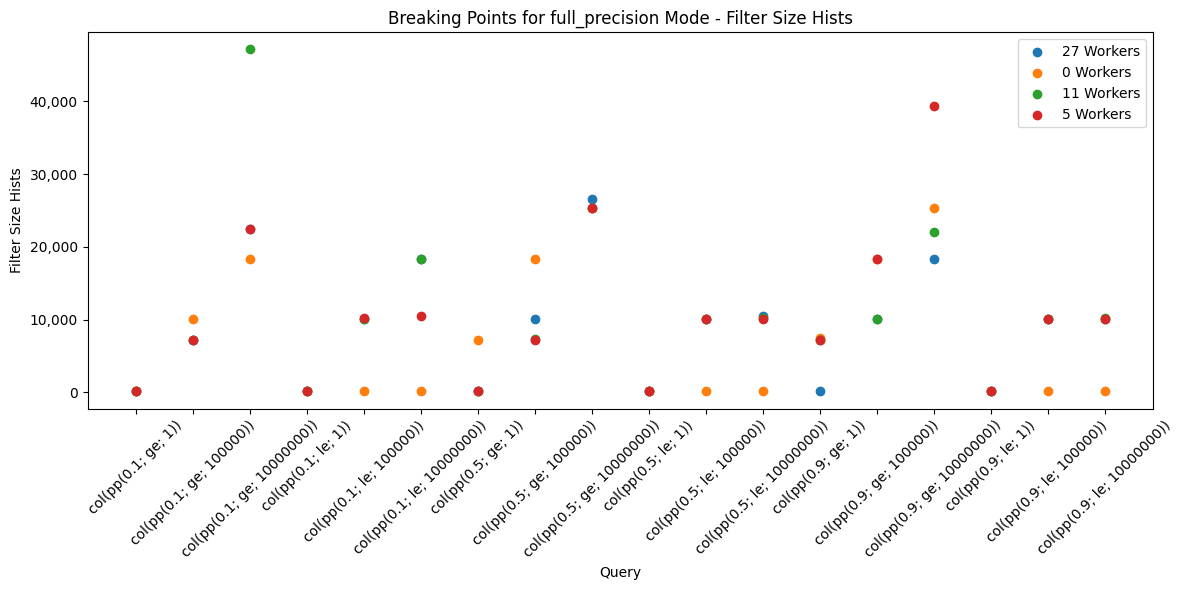

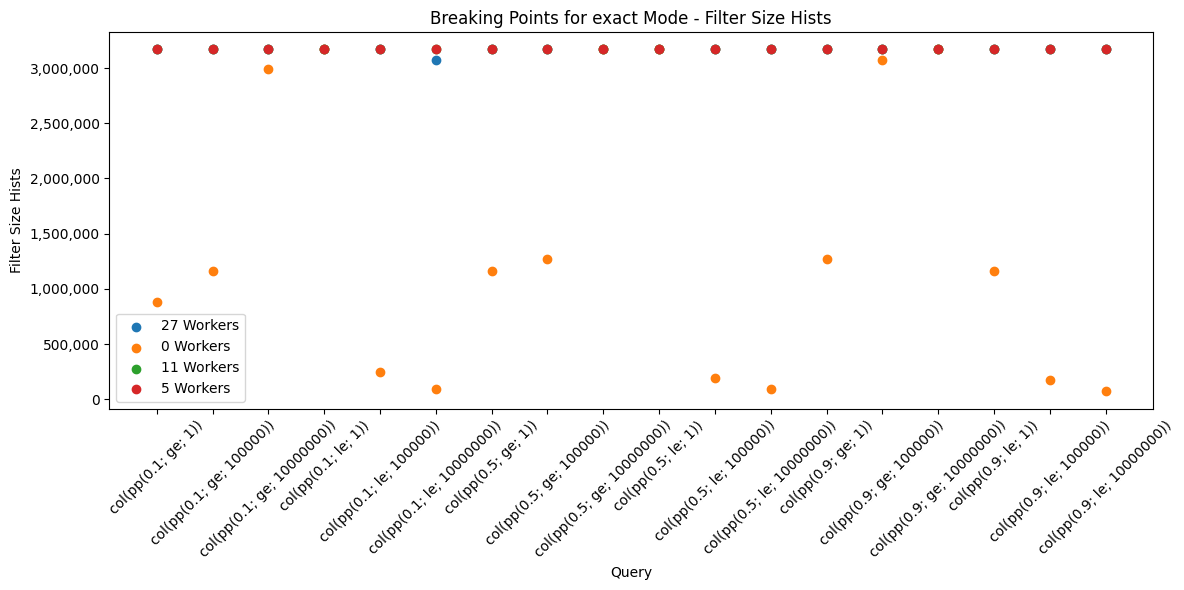

In [6]:
# plot breaking points per query per num_workers as points in two plots

fainder_modes = df_latest["fainder_mode"].unique()
for fainder_mode in fainder_modes:
    df_filtered = df_latest[df_latest["fainder_mode"] == fainder_mode]
    
    # Create a figure with just one subplot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for num_workers in df_filtered["num_workers"].unique():
        df_worker = df_filtered[df_filtered["num_workers"] == num_workers]
        # Group by query and find the max filter size
        grouped = df_worker.groupby("query")["filter_size"].max().reset_index()
        # Plotting points instead of bars
        ax.scatter(grouped["query"], grouped["filter_size"], label=f"{num_workers} Workers")
    
    ax.set_title(f"Breaking Points for {fainder_mode} Mode - Filter Size Hists")
    ax.set_ylabel("Filter Size Hists")
    ax.set_xlabel("Query")
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    
    # Format y-axis with commas
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ",")))
    
    plt.tight_layout()
    plt.savefig(f"excecution/breaking_points_{fainder_mode}.png")
    plt.show()
